In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from ipywidgets import *

In [3]:
# test_data_path = 'dataset/4.json'
test_data_path = '/home/prota/Desktop/graduate_work/fin/588.json'
data_dict = None
with open(test_data_path) as f:
    data_dict = json.load(f)

In [5]:
len(data_dict['object_positions'][0])

499

In [7]:
from pathlib import Path
import h5py

In [15]:
data_dir = Path("h5_data/train")
# rollout_data_dir = Path("h5_data/valid/0/")
rollout_data_dir = Path("/home/prota/Desktop/graduate_work/DPI-Net/data/data_DustBox/valid/0")
frames_number = len(os.listdir(rollout_data_dir))
with open("h5_data/info.json") as f:
    info_dict = json.load(f)
dt = 1./30.
use_velocity = True

data_dict = {'end_frame': frames_number-1,
             'left_border': info_dict['left_border'],
             'right_border': info_dict['right_border'],
             'bottom_border': info_dict['bottom_border'],
             'top_border': info_dict['top_border'],
             'object_positions': [[]for _ in range(info_dict['objects_number'])], 
             'particle_positions': [[]for _ in range(info_dict['particles_number'])]} 

In [16]:
for frame_id in range(frames_number):
    frame_path = rollout_data_dir / (str(frame_id)+".h5")
    frame_data = h5py.File(frame_path, 'r')
    frame_data_positions = np.array(frame_data["positions"])
    frame_data_velocities = np.array(frame_data["velocities"])

    frame_particle_positions = frame_data_positions[:len(data_dict['particle_positions'])]
    frame_particle_velocities = frame_data_velocities[:len(data_dict['particle_positions'])]
    
    frame_object_positions = frame_data_positions[len(data_dict['particle_positions']):(len(data_dict['particle_positions'])+len(data_dict['object_positions']))]
    frame_object_velocities = frame_data_velocities[len(data_dict['particle_positions']):(len(data_dict['particle_positions'])+len(data_dict['object_positions']))]

    for particle_id in range(len(frame_particle_positions)):
        position = None
        if use_velocity:
            if frame_id == 0:
                position = frame_particle_positions[particle_id] 
            else:
                position = data_dict['particle_positions'][particle_id][-1]+frame_particle_velocities[particle_id]*dt
        else:
            position = frame_particle_positions[particle_id]
        data_dict['particle_positions'][particle_id].append(position)

    for object_id in range(len(frame_object_positions)):
        position = None
        if use_velocity:
            if frame_id == 0:
                position = frame_particle_positions[object_id] 
            else:
                position = data_dict['particle_positions'][object_id][-1]+frame_particle_velocities[object_id]*dt
        else:
            position = frame_particle_positions[object_id]
       
        data_dict['object_positions'][object_id].append(frame_object_positions[object_id])


In [2]:
# test_data_path = 'dataset/4.json'
test_data_path = 'result.json'
data_dict = None
with open(test_data_path) as f:
    data_dict = json.load(f)

In [3]:
len(data_dict['object_positions'])

56

interactive(children=(IntSlider(value=0, description='frame', max=498), Output()), _dom_classes=('widget-inter…

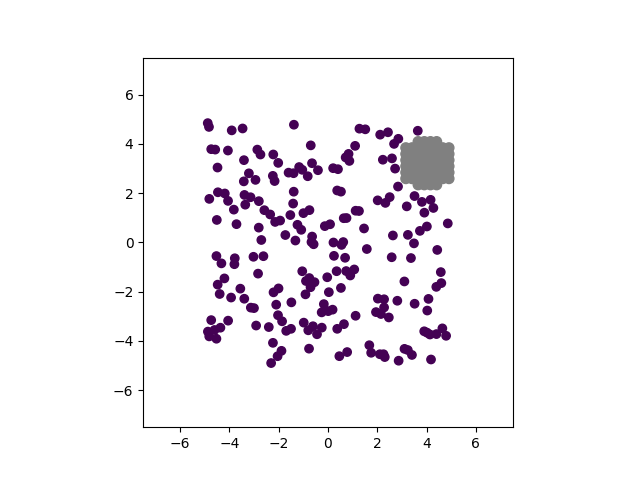

In [4]:
%matplotlib ipympl
fig, ax = plt.subplots()

ax.set_xlim([data_dict['left_border'], data_dict['right_border']])
ax.set_ylim([data_dict['bottom_border'], data_dict['top_border']])
ax.set_aspect('equal')

objects_number = len(data_dict["object_positions"])
object_size = 0.2
circles = []
particles_scatter = ax.scatter([], [], c=[], norm=plt.Normalize(0,1))
for object_id in range(objects_number):
    object_x, object_y = data_dict['object_positions'][object_id][0][0], data_dict['object_positions'][object_id][0][1]
    circle = plt.Circle((object_x, object_y), object_size, color='grey')
    circles.append(circle)
    ax.add_patch(circle)

def update(frame = 0):
    for object_id in range(objects_number):
        object_x, object_y = data_dict['object_positions'][object_id][frame][0], data_dict['object_positions'][object_id][frame][1]
        circles[object_id].center = object_x, object_y
        
    particles_x, particles_y = [], []
    particle_positions = []
    particle_colors = []

    for particle_id in range(len(data_dict['particle_positions'])):
        particle_x, particle_y = None, None
        particle_color = 0
        if len(data_dict['particle_positions'][particle_id]):
            if frame >= len(data_dict['particle_positions'][particle_id]):
                particle_x, particle_y = data_dict['particle_positions'][particle_id][-1][0], data_dict['particle_positions'][particle_id][-1][1]
                particle_color = 1
            else:
                particle_x, particle_y = data_dict['particle_positions'][particle_id][frame][0], data_dict['particle_positions'][particle_id][frame][1]
        particle_positions.append([particle_x, particle_y])
        particle_colors.append(particle_color)
        particles_x.append(particle_x)
        particles_y.append(particle_y)
    particles_scatter.set_offsets(particle_positions)
    particles_scatter.set_array(particle_colors)
    fig.canvas.draw_idle()

interact(update, frame = (0, data_dict['end_frame'], 1));